## Variable Setup for Baseline Classification Models

This script sets up the variables used in the models. This involves defining the site and the compound being explored, extracting the meteorological data and reading and balancing the 'true' baselines (obtained from Alaistair Manning at the Met Office). The data is then combined to create a dataframe that is saved for use in the models.

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import config

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'
meteorological_data_path = data_path/'meteorological_data'
saving_path = data_path/'saved_files'

#### Functions

In [3]:
def read_manning(site):
    """
    Extracting Alistair's baseline flags for a given site

    Args:
    - site (str): Site code (e.g., MHD)

    Returns:
    - df (pandas.DataFrame): DataFrame with baseline flags as a binary variable
    """
    
    site_translator = {"MHD":"MH", "CGO":"CG", "GSN":"GS", "JFJ":"J1", "CMN":"M5", "THD":"TH", "ZEP":"ZE"}

    # Filtering so only including data relevant to the given site
    files = (data_path / "manning_baselines").glob(f"{site_translator[site]}*.txt")

    dfs = []

    # Looping through each of the files for the given site
    for file in files:

        # Read the data, skipping metadata, putting into pandas dataframe
        data = pd.read_csv(file, skiprows=6, delim_whitespace=True)

        # Setting the index of the dataframe to be the extracted datetime and naming it time
        data.index = pd.to_datetime(data['YY'].astype(str) + "-" + \
                                    data['MM'].astype(str) + "-" + \
                                    data['DD'].astype(str) + " " + \
                                    data['HH'].astype(str) + ":00:00")

        data.index.name = "time"
        
        # Adding the 'Ct' column to the previously created empty list
        dfs.append(data[["Ct"]])
    
    # Creating a dataframe from the list containing all the 'Ct' values
    df = pd.concat(dfs)

    df.sort_index(inplace=True)
    
    # Replace all values in Ct column less than 10 or greater than 20 with 0
    # not baseline values
    df.loc[(df['Ct'] < 10) | (df['Ct'] >= 20), 'Ct'] = 0

    # Replace all values between 10 and 19 with 1
    # baseline values
    df.loc[(df['Ct'] >= 10) & (df['Ct'] < 20), 'Ct'] = 1

    # Rename Ct column to "baseline"
    df.rename(columns={'Ct': 'baseline'}, inplace=True)

    return df

In [4]:
def balance_baselines(ds, minority_ratio): 
    """
    Balances the dataset by randomly undersampling non-baseline data points.

    Args:
    - ds (xarray.Dataset): The dataset to be balanced.
    - minority_ratio (float): The desired ratio of baseline (minority class) data points in the final dataset. 
                            For example, 0.4 means 40% of data points will be baseline.

    Returns:
    - xarray.Dataset: The balanced dataset where the ratio of baseline to non-baseline data points is as specified by the `minority_ratio` argument.

    Raises:
    - ValueError: If the counts of baseline and non-baseline values are not in the expected ratio (within a tolerance of 1%).

    """

    # counting number of baseline&non-baseline data points
    baseline_count = ds['baseline'].where(ds['baseline']==1).count()
    non_baseline_count = ds['baseline'].where(ds['baseline']==0).count()

    # calculating the minority class count (expected to be baseline)
    minority_count = int(min(baseline_count, non_baseline_count))

    # calculating the majority class count based on majority_ratio and minority_count
    majority_ratio = 1 - minority_ratio
    majority_count = int(minority_count * (majority_ratio/minority_ratio))

    # randomly undersampling non-baseline based on majority_count
    np.random.seed(42)
    undersampled_non_baseline = ds.where(ds['baseline'] == 0, drop=True)
    undersampled_non_baseline = undersampled_non_baseline.isel(time=np.random.choice(undersampled_non_baseline.dims['time'], majority_count, replace=False))

    # combining the the undersampled non-baseline with the baseline values
    balanced_ds = xr.merge([ds.where(ds['baseline'] == 1), undersampled_non_baseline])
    balanced_ds = balanced_ds.sortby('time')

    # checking balance
    new_baseline_count = balanced_ds['baseline'].where(balanced_ds['baseline']==1).count()
    new_non_baseline_count = balanced_ds['baseline'].where(balanced_ds['baseline']==0).count()

    # verifying that the ratio of baseline:non-baseline data points is as expected (within a tolerance of 1%)
    tolerance = 0.01
    upper_bound = (1+tolerance)*(majority_ratio/minority_ratio)
    lower_bound = (1-tolerance)*(majority_ratio/minority_ratio)

    if(lower_bound <= (new_non_baseline_count/new_baseline_count) <= upper_bound):
        return balanced_ds
    else:
        raise ValueError("The counts of baseline and non-baseline values are not in the expected ratio.")

In [5]:
def add_shifted_time(df):
    """
    Adds columns with wind data shifted by 4 hours (up two index rows) to the input dataframe.

    Args:
    - df (pd.DataFrame): The input dataframe.

    Returns:
    - pd.DataFrame: The dataframe with shifted time columns.
    """

    # copying dataframe
    df_ = df.copy()    

    # extracting wind colunmns
    u10_columns = [f"u10_{point}" for point in points]
    v10_columns = [f"v10_{point}" for point in points]
    u850_columns = [f"u850_{point}" for point in points]
    v850_columns = [f"v850_{point}" for point in points]
    u500_columns = [f"u500_{point}" for point in points]
    v500_columns = [f"v500_{point}" for point in points]
    wind_columns = u10_columns + v10_columns + u850_columns + v850_columns + u500_columns + v500_columns

    # checking if adding a shifted time column has already been done - in which case, remove it before adding it again
    if f'u10_0_past' in df_.columns:
        df_ = df_.drop(columns=[col + f'_past' for col in wind_columns])
        print("Shifted time columns already exist and have been removed. Note that redoing readding shifted time will remove additional columns.")

    # create shifted columns
    shifted_columns = [col + '_past' for col in wind_columns]

    # Create a dictionary for the shifted columns
    shifted_dict = {}

    for col, shifted_col in zip(wind_columns, shifted_columns):
        # Shift the column values up by two rows
        shifted_dict[shifted_col] = df_[col].shift(3)

    # Convert the dictionary to a DataFrame
    df_shifted = pd.DataFrame(shifted_dict)

    # Concatenate the original DataFrame with the new DataFrame
    df_ = pd.concat([df_, df_shifted], axis=1)

    # dropping the first two rows as NaN values
    df_ = df_.iloc[3:]

    return df_

#### Defining Site & Compound

In [6]:
site = config.site
site_name = config.site_dict[site]
compound = config.compound
balance = True

print(f"Exploring {compound} at {site_name}.")

Exploring hfc-152a at Mace Head, Ireland.


#### Setting Up Variables

In [7]:
# extracting Manning's baseline flags for given site
df = read_manning(site)

# converting to xarray dataset
ds_flags = df.to_xarray()

# balancing the dataset
balanced_ds_flags = balance_baselines(ds_flags, 0.7)

C:\Users\kirst\AppData\Local\Temp\ipykernel_3684\625774816.py:32: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  undersampled_non_baseline = undersampled_non_baseline.isel(time=np.random.choice(undersampled_non_baseline.dims['time'], majority_count, replace=False))


In [8]:
# loading in meteorological data for given site
# 10m wind
ds_10m_u = xr.open_mfdataset((meteorological_data_path/'ECMWF'/site/'10m_wind_grid').glob('*u*.nc'))
ds_10m_v = xr.open_mfdataset((meteorological_data_path/'ECMWF'/site/'10m_wind_grid').glob('*v*.nc'))

# 850hPa wind
ds_850hPa_u = xr.open_mfdataset((meteorological_data_path/'ECMWF'/site/'850hPa_wind_grid').glob('*u*.nc'))
ds_850hPa_v = xr.open_mfdataset((meteorological_data_path/'ECMWF'/site/'850hPa_wind_grid').glob('*v*.nc'))

# 500hPa wind
ds_500hPa_u = xr.open_mfdataset((meteorological_data_path/'ECMWF'/site/'500hPa_wind_grid').glob('*u*.nc'))
ds_500hPa_v = xr.open_mfdataset((meteorological_data_path/'ECMWF'/site/'500hPa_wind_grid').glob('*v*.nc'))

# surface pressure
# ds_sp = xr.open_mfdataset((meteorological_data_path/'ECMWF'/site/'surface_pressure').glob('*.nc'))
ds_sp = xr.open_mfdataset((meteorological_data_path/'ECMWF'/site/'surface_pressure').glob('*.nc'))

# boundary layer height
ds_blh = xr.open_mfdataset((meteorological_data_path/'ECMWF'/site/'boundary_layer_height').glob('*.nc'))

c:\Users\kirst\OneDrive\Kirstin\Uni\Year4\MSciProject\my_code\optimising_algorithm\venv\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [9]:
# grabbing the AGAGE data
# original data
# ds_agage = xr.open_dataset(data_path / f"AGAGE/data-gcms-nc/AGAGE-GCMS-Medusa_{site}_{compound}.nc")

# reprocessed data
ds_agage = xr.open_dataset(next((data_path / "AGAGE" / "AGAGE-public-files" / compound).glob(f"*{site}_{compound}.nc")))                 

In [10]:
# creating an xarray dataset with all the meteorological data, the AGAGE data, and the baseline flags
# unbalanced dataset
data_ds = xr.merge([ds_agage.mf,
                   ds_10m_u.reindex_like(ds_agage, method="nearest"),
                   ds_10m_v.reindex_like(ds_agage, method="nearest"),
                   ds_850hPa_u.reindex_like(ds_agage, method="nearest"),
                   ds_850hPa_v.reindex_like(ds_agage, method="nearest"),
                   ds_500hPa_u.reindex_like(ds_agage, method="nearest"),
                   ds_500hPa_v.reindex_like(ds_agage, method="nearest"),
                   ds_sp.reindex_like(ds_agage, method="nearest"),
                   ds_blh.reindex_like(ds_agage, method="nearest"),
                   ds_flags.reindex_like(ds_agage, method="nearest")],
                   compat="override")

# balanced dataset
balanced_data_ds = xr.merge([ds_agage.mf,
                   ds_10m_u.reindex_like(ds_agage, method="nearest"),
                   ds_10m_v.reindex_like(ds_agage, method="nearest"),
                   ds_850hPa_u.reindex_like(ds_agage, method="nearest"),
                   ds_850hPa_v.reindex_like(ds_agage, method="nearest"),
                   ds_500hPa_u.reindex_like(ds_agage, method="nearest"),
                   ds_500hPa_v.reindex_like(ds_agage, method="nearest"),
                   ds_sp.reindex_like(ds_agage, method="nearest"),
                   ds_blh.reindex_like(ds_agage, method="nearest"),
                   balanced_ds_flags.reindex_like(ds_agage, method="nearest")],
                   compat="override")


# removing the level dimension from the dataset
data_ds = data_ds.drop_vars('level')
balanced_data_ds = balanced_data_ds.drop_vars('level')


# removing associated variable values to the baseline values removed in balancing (uses a mask)
balanced_data_ds = data_ds.where(~np.isnan(data_ds['baseline']), drop=True)

# saving these datasets for use in model evaluation/benchmark analysis
data_ds.to_netcdf(saving_path/'data_ds.nc')
balanced_data_ds.to_netcdf(saving_path/'data_balanced_ds.nc')

Original mean: 8.707, Balanced mean: 8.707. Percentage difference: 0.00%
Original std: 2.810, Balanced std: 2.810. Percentage difference: 0.00%


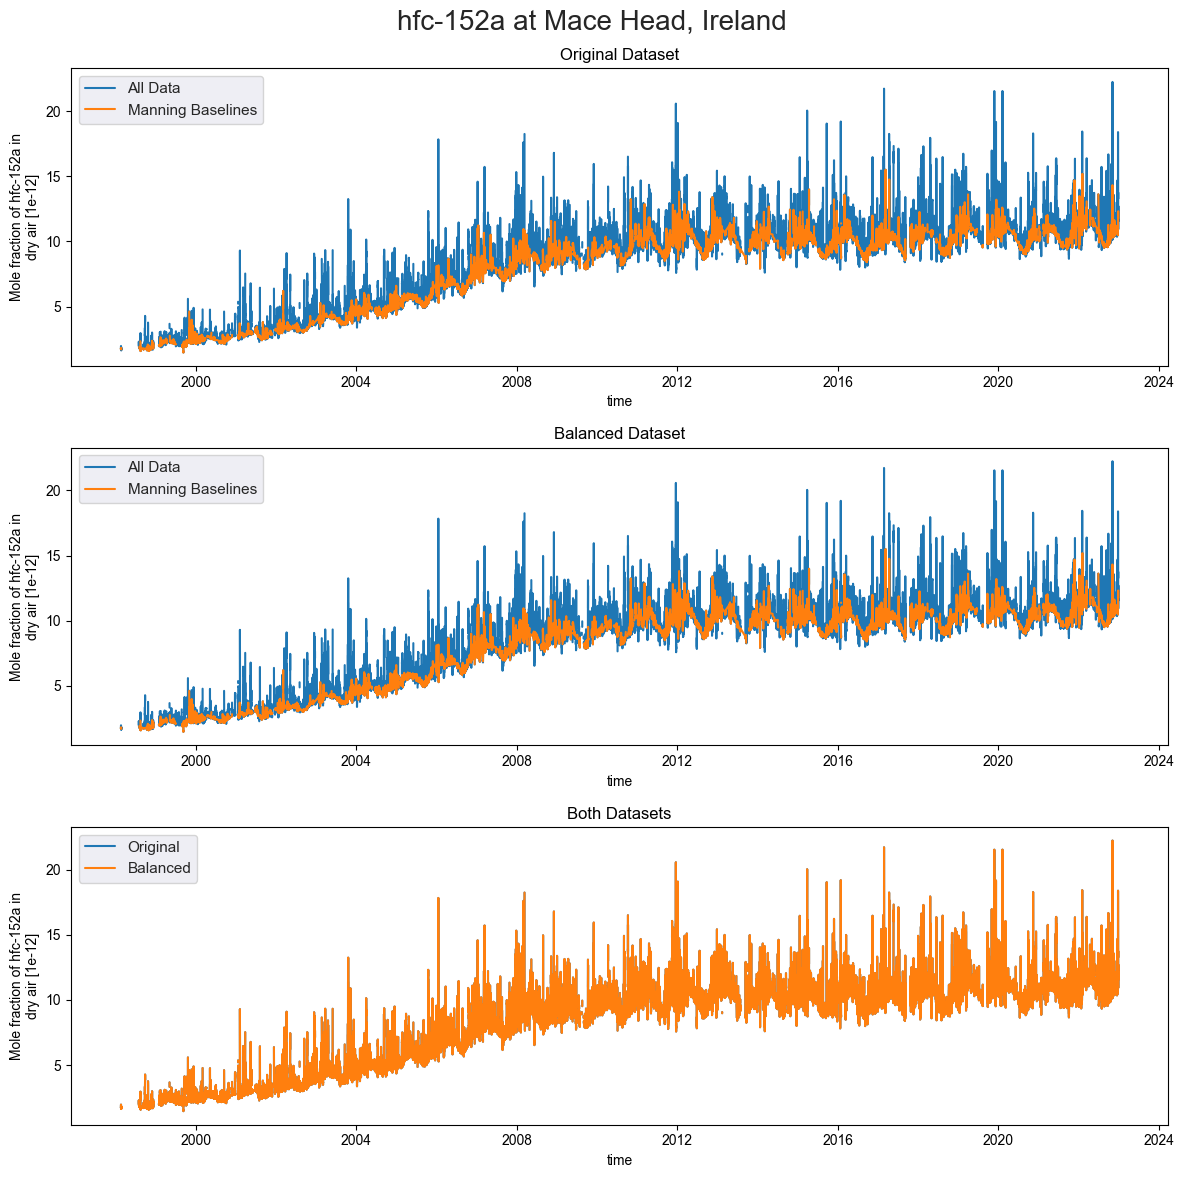

In [11]:
# comparing the mole fraction time series for the original and balanced datasets
# calculating statistics
original_mf = data_ds.mf.values
original_mf = original_mf[~np.isnan(original_mf)]
balanced_mf = balanced_data_ds.mf.values
balanced_mf = balanced_mf[~np.isnan(balanced_mf)]

original_mean = original_mf.mean()
original_std = original_mf.std()
balanced_mean = balanced_mf.mean()
balanced_std = balanced_mf.std()

print(f"Original mean: {original_mean:.3f}, Balanced mean: {balanced_mean:.3f}. Percentage difference: {(abs(original_mean-balanced_mean)/original_mean)*100:.2f}%"
      f"\nOriginal std: {original_std:.3f}, Balanced std: {balanced_std:.3f}. Percentage difference: {(abs(original_std-balanced_std)/original_std)*100:.2f}%")

# plotting
fig, axs = plt.subplots(3,1, figsize=(12,12))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

data_ds.mf.plot(ax=axs[0], label="All Data")
data_ds.where(data_ds.baseline == 1, drop=True).mf.plot(ax=axs[0], label="Manning Baselines")
axs[0].set_title("Original Dataset")
axs[0].legend()

balanced_data_ds.mf.plot(ax=axs[1], label="All Data")
balanced_data_ds.where(balanced_data_ds.baseline == 1, drop=True).mf.plot(ax=axs[1], label="Manning Baselines")
axs[1].set_title("Balanced Dataset")
axs[1].legend()

data_ds.mf.plot(ax=axs[2], label="Original")
balanced_data_ds.mf.plot(ax=axs[2], label="Balanced")
axs[2].set_title("Both Datasets")
axs[2].legend()

fig.suptitle(f"{compound} at {site_name}", fontsize=20)
fig.set_tight_layout(True)

In [12]:
using_balanced = True

if using_balanced == False:
    data_df = pd.DataFrame({"flag": data_ds.baseline.values}, index=data_ds.time.values)

    points = data_ds.points.values

    u10_columns = [f"u10_{point}" for point in points]
    v10_columns = [f"v10_{point}" for point in points]
    u850_columns = [f"u850_{point}" for point in points]
    v850_columns = [f"v850_{point}" for point in points]
    u500_columns = [f"u500_{point}" for point in points]
    v500_columns = [f"v500_{point}" for point in points]

    # concatenating the dataframe with the meteorological & temporal data
    data_df = pd.concat([
        data_df,
        pd.DataFrame(data_ds.u10.sel(points=points).values, columns=u10_columns, index=data_df.index),
        pd.DataFrame(data_ds.v10.sel(points=points).values, columns=v10_columns, index=data_df.index),
        pd.DataFrame(data_ds.u850.sel(points=points).values, columns=u850_columns, index=data_df.index),
        pd.DataFrame(data_ds.v850.sel(points=points).values, columns=v850_columns, index=data_df.index),
        pd.DataFrame(data_ds.u500.sel(points=points).values, columns=u500_columns, index=data_df.index),
        pd.DataFrame(data_ds.v500.sel(points=points).values, columns=v500_columns, index=data_df.index),
        pd.DataFrame({"sp": data_ds.sp.values}, index=data_df.index),
        pd.DataFrame({"blh": data_ds.blh.values}, index=data_df.index),
        pd.DataFrame({"time_of_day": data_df.index.hour}, index=data_df.index),
        pd.DataFrame({"day_of_year": data_df.index.dayofyear}, index=data_df.index)],
        axis=1)
    
elif using_balanced == True:
    data_df = pd.DataFrame({"flag": balanced_data_ds.baseline.values}, index=balanced_data_ds.time.values)

    points = balanced_data_ds.points.values

    u10_columns = [f"u10_{point}" for point in points]
    v10_columns = [f"v10_{point}" for point in points]
    u850_columns = [f"u850_{point}" for point in points]
    v850_columns = [f"v850_{point}" for point in points]
    u500_columns = [f"u500_{point}" for point in points]
    v500_columns = [f"v500_{point}" for point in points]

    # concatenating the dataframe with the meteorological & temporal data
    data_df = pd.concat([
        data_df,
        pd.DataFrame(balanced_data_ds.u10.sel(points=points).values, columns=u10_columns, index=data_df.index),
        pd.DataFrame(balanced_data_ds.v10.sel(points=points).values, columns=v10_columns, index=data_df.index),
        pd.DataFrame(balanced_data_ds.u850.sel(points=points).values, columns=u850_columns, index=data_df.index),
        pd.DataFrame(balanced_data_ds.v850.sel(points=points).values, columns=v850_columns, index=data_df.index),
        pd.DataFrame(balanced_data_ds.u500.sel(points=points).values, columns=u500_columns, index=data_df.index),
        pd.DataFrame(balanced_data_ds.v500.sel(points=points).values, columns=v500_columns, index=data_df.index),
        pd.DataFrame({"sp": balanced_data_ds.sp.values}, index=data_df.index),
        pd.DataFrame({"blh": balanced_data_ds.blh.values}, index=data_df.index),
        pd.DataFrame({"time_of_day": data_df.index.hour}, index=data_df.index),
        pd.DataFrame({"day_of_year": data_df.index.dayofyear}, index=data_df.index)],
        axis=1)

In [13]:
data_df = add_shifted_time(data_df)
data_df.index.name = "time"

data_df.head()

,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,u10_8,...,v500_7_past,v500_8_past,v500_9_past,v500_10_past,v500_11_past,v500_12_past,v500_13_past,v500_14_past,v500_15_past,v500_16_past
time,,,,,,,,,,,,,,,,,,,,,
1998-01-01 15:44:00,0.0,15.799965,8.988737,-4.706259,0.756090,6.877802,16.989100,16.102343,19.519775,13.169040,...,4.853133,6.955009,NaN,NaN,NaN,NaN,-28.050055,-20.560896,11.438682,NaN
1998-01-01 19:46:00,0.0,14.265259,10.862497,-5.131707,10.005083,16.575062,14.961296,16.795120,16.689981,13.517059,...,13.810658,17.628082,NaN,NaN,NaN,NaN,-19.750593,-15.995375,16.693369,NaN
1998-01-01 23:47:00,0.0,10.893469,9.758943,4.233835,8.930869,12.206486,15.960527,21.415543,15.661409,20.204403,...,5.615963,22.959709,NaN,NaN,NaN,NaN,-21.638025,-12.137025,-1.259330,NaN
1998-01-02 03:48:00,0.0,12.009249,9.357132,1.915067,5.947849,14.825186,22.372391,19.720274,18.638725,18.762609,...,-1.629286,18.978586,NaN,NaN,NaN,NaN,-20.773703,-11.857102,1.849285,NaN
1998-01-02 07:50:00,1.0,14.852083,9.324530,1.611875,7.808569,18.997339,19.074768,17.866888,21.336483,19.735760,...,6.154528,8.837529,NaN,NaN,NaN,NaN,-17.280399,-11.996245,-4.480896,NaN


In [14]:
columns_with_nan = data_df.columns[data_df.isna().any()]
print(columns_with_nan)
print(f"Number of columns containing NaN values: {columns_with_nan.size}")

data_df = data_df.dropna(axis=1)

Index(['u10_9', 'u10_10', 'u10_11', 'u10_12', 'u10_16', 'v10_9', 'v10_10',
       'v10_11', 'v10_12', 'v10_16', 'u850_9', 'u850_10', 'u850_11', 'u850_12',
       'u850_16', 'v850_9', 'v850_10', 'v850_11', 'v850_12', 'v850_16',
       'u500_9', 'u500_10', 'u500_11', 'u500_12', 'u500_16', 'v500_9',
       'v500_10', 'v500_11', 'v500_12', 'v500_16', 'u10_9_past', 'u10_10_past',
       'u10_11_past', 'u10_12_past', 'u10_16_past', 'v10_9_past',
       'v10_10_past', 'v10_11_past', 'v10_12_past', 'v10_16_past',
       'u850_9_past', 'u850_10_past', 'u850_11_past', 'u850_12_past',
       'u850_16_past', 'v850_9_past', 'v850_10_past', 'v850_11_past',
       'v850_12_past', 'v850_16_past', 'u500_9_past', 'u500_10_past',
       'u500_11_past', 'u500_12_past', 'u500_16_past', 'v500_9_past',
       'v500_10_past', 'v500_11_past', 'v500_12_past', 'v500_16_past'],
      dtype='object')
Number of columns containing NaN values: 60


In [15]:
# option for saving the dataframe for the model before dimensionality reduction
data_df.to_csv(saving_path/"for_model.csv")

#### Dimensionality Reduction

I'm reducing the dimensions of the dataset as has a huge number of features - can identify the most important features and remove noise.

In [32]:
# dropping the flag column as it is the target variable - added back in later
data_for_pca = data_df.drop(columns='flag')

In [33]:
# redefining column name lists to include shifted wind data
u10_columns = [col for col in data_for_pca.columns if 'u10' in col]
v10_columns = [col for col in data_for_pca.columns if 'v10' in col]
u850_columns = [col for col in data_for_pca.columns if 'u850' in col]
v850_columns = [col for col in data_for_pca.columns if 'v850' in col]
u500_columns = [col for col in data_for_pca.columns if 'u500' in col]
v500_columns = [col for col in data_for_pca.columns if 'v500' in col]

wind_columns = u10_columns + v10_columns + u850_columns + v850_columns + u500_columns + v500_columns

In [41]:
# standardising the data for PCA based on column groups
# groups = wind (groups by direction and height), sp, blh, time_of_day, day_of_year
column_groups = {
    'u10': u10_columns,
    'v10': v10_columns,
    'u850': u850_columns,
    'v850': v850_columns,
    'u500': u500_columns,
    'v500': v500_columns,
    'sp': ['sp'],
    'blh': ['blh'],
    'time_of_day': ['time_of_day'],
    'day_of_year': ['day_of_year']
}

# creating dictionary to hold standardised data
standardised_data = {}

# standardising each group of columns
for group, columns in column_groups.items():
    data = data_for_pca[columns]
    
    # reshape if only one column - applicable for all but the wind columns
    if data.shape[1] == 1:
        data = data.values.reshape(-1, 1)
    
    standardised_data[group] = StandardScaler().fit_transform(data)


# concatenating the standardised data into a dataframe for use in PCA
# first converting the standardised data into dataframes so dimensions are correct for concatenation
dfs = [pd.DataFrame(data, columns=columns) for group, columns, data in zip(column_groups.keys(), column_groups.values(), standardised_data.values())]

# concatenating the dataframes
data_for_pca = pd.concat(dfs, axis=1)

data_for_pca.index = data_df.index

Text(0, -30, '99% Explained Variance = 109 components')

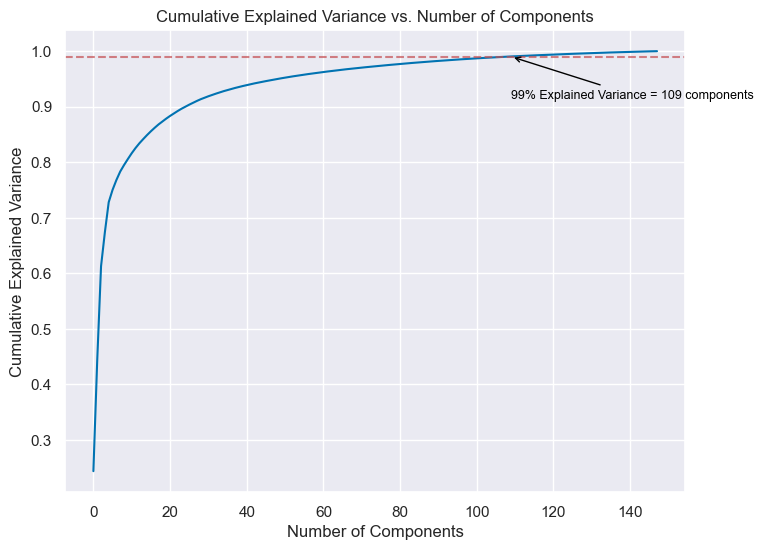

In [42]:
# exploring the explained variance ratio for different numbers of components to find the optimal number of components
# fitting the PCA with the standardised data
pca = PCA()
pca.fit(data_for_pca)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# plotting the cumulative explained variance
fig, ax = plt.subplots(figsize=(8,6))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

ax.plot(cumulative_variance)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_title('Cumulative Explained Variance vs. Number of Components')

# adding a horizontal line at the desired explained variance
desired_explained_variance = 0.99
ax.axhline(y=desired_explained_variance, color='r', linestyle='--', alpha=0.7)

# annotating plot with the corresponding number of components
desired_components = np.argmax(cumulative_variance >= desired_explained_variance) + 1
ax.annotate(f'{desired_explained_variance*100:.0f}% Explained Variance = {desired_components} components',
             xy=(desired_components, desired_explained_variance), xycoords='data',
             xytext=(0, -30), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='black'),
             fontsize=9, color='black')

In [43]:
# fitting the PCA with the desired number of components
num_components = desired_components
pca = PCA(n_components=num_components)

# fitting the PCA with my data
pca_data = pca.fit_transform(data_for_pca)
pca_components = pd.DataFrame(pca_data, columns=[f"PC{i+1}" for i in range(num_components)], index=data_df.index)
pca_components.sample(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109
time,,,,,,,,,,,,,,,,,,,,,
2008-10-23 22:53:00,7.613536,10.781845,-3.244379,-5.492910,-2.241133,1.417834,1.782443,-0.434727,0.624436,0.863824,...,-0.293515,-0.024497,0.492143,-0.217025,-0.374284,0.393008,-0.090826,0.038909,-0.280434,-0.428054
2008-06-10 12:06:00,-3.571939,3.084012,-7.985925,-3.069196,-1.177426,-0.885455,1.616800,-1.603439,0.008866,-0.001824,...,-0.026308,-0.030681,0.077462,-0.054153,0.047976,0.159199,0.377021,0.003340,-0.373033,-0.213364
2012-04-02 00:34:00,-6.038086,-1.752177,-2.177951,-0.840301,-1.858183,-1.695019,-0.319474,-0.591648,0.825533,0.252043,...,0.164529,0.086563,0.044891,-0.023213,0.216658,-0.232539,-0.247046,0.120517,0.181590,-0.171269
2008-07-03 01:32:00,2.418977,-1.001347,4.415226,-3.321437,3.451033,1.397311,2.716762,0.719304,0.394578,-0.971028,...,-0.106376,-0.031368,0.088459,-0.075975,-0.088854,-0.055047,0.123591,-0.008700,-0.249476,-0.021385
2019-08-11 15:56:00,-3.670021,1.800015,3.924219,-1.204763,-0.995729,1.005213,-0.023418,2.020802,0.330013,-1.372289,...,0.111662,0.181107,-0.121312,0.137960,-0.148515,-0.186404,0.184839,-0.175563,0.054952,-0.024365


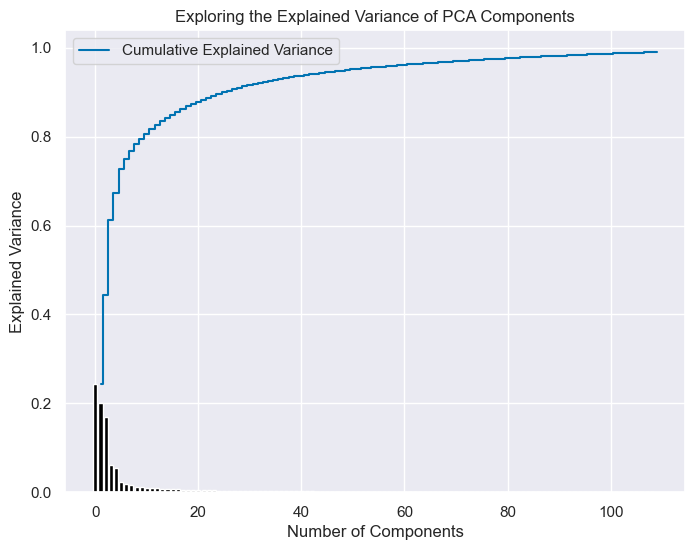

In [28]:
# plotting a cumulative explained variance plot for the PCA components
features = range(pca.n_components_)
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(8,6))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

ax.bar(features, pca.explained_variance_ratio_, color='black')
ax.step(range(1,(pca_components.shape[1]+1)), cum_var_exp, where='mid', label='Cumulative Explained Variance')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Explained Variance')
ax.set_title('Exploring the Explained Variance of PCA Components')
ax.legend()

In [31]:
# adding the flag column back in and saving the dataframe for use in the model
pca_components['flag'] = data_df['flag']
pca_components.to_csv(saving_path/'for_model.csv', index=True)